# **Task:** Find country collaborations in research grants

The results of a query can be saved as a [Pandas](https://pandas.pydata.org) dataframe by adding a variable name to the `%%bigquery` magic

In [ ]:
%%bigquery edges

WITH country_project AS (
  SELECT countryCode AS country,
           target AS project_id
  FROM oag_v9_0_1.organizations JOIN oag_v9_0_1.relations
      ON relationName = 'isParticipant' AND source = organizations.id
  WHERE country IS NOT NULL
)
SELECT l.country AS left_country,
       r.country AS right_country,
       COUNT(*) AS count
FROM country_project AS l JOIN country_project AS r
      ON l.project_id = r.project_id AND l.country <= r.country
GROUP BY left_country, right_country
ORDER BY count DESC

Query is running:   0%|          |

Downloading:   0%|          |

Once done, the variable is properly set

In [ ]:
edges

,left_country,right_country,count
0,US,US,415642
1,GB,GB,338117
2,DE,DE,125285
3,ES,ES,95752
4,IT,IT,94270
...,...,...,...
6929,CZ,MG,1
6930,NA,SI,1
6931,RS,VE,1
6932,AW,ES,1


In [ ]:
type(edges)

pandas.core.frame.DataFrame

As an alternative, one can be more verbose and run the query from Python (this allows to programmatically change the query, e.g., to run multiple times a parametrised query

In [ ]:
from google.cloud import bigquery
client = bigquery.Client()

sql = """
WITH country_project AS (
  SELECT countryCode AS country,
           target AS project_id
  FROM oag_v9_0_1.organizations JOIN oag_v9_0_1.relations
      ON relationName = 'isParticipant' AND source = organizations.id
  WHERE country IS NOT NULL

)
SELECT l.country AS left_country,
       r.country AS right_country,
       COUNT(*) AS count
FROM country_project AS l JOIN country_project AS r
      ON l.project_id = r.project_id AND l.country <= r.country
GROUP BY left_country, right_country
ORDER BY count DESC
"""

edges = client.query_and_wait(sql).to_dataframe()
edges

,left_country,right_country,count
0,US,US,415642
1,GB,GB,338117
2,DE,DE,125285
3,ES,ES,95752
4,IT,IT,94270
...,...,...,...
6929,HK,HR,1
6930,MT,SN,1
6931,IN,MD,1
6932,NP,RW,1


## **Subtask:** plot the network

Additional Python packages can always be installed like so

In [ ]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.6 MB/s eta 0:00:00


Ok. Now let's import the `igraph` and load the results returned from our last query as tuples of a new network

In [ ]:
import igraph as ig

G = ig.Graph.TupleList(
    edges=edges[['left_country', 'right_country', 'count']].values,
    vertex_name_attr='country_code',
    edge_attrs = ['weight'],
    directed=False)

Let's count the nodes (i.e., countries) in the network

In [ ]:
G.vcount()

209

Let's count the edges in the network (i.e., the collaboration links)


In [ ]:
G.ecount()

6934

In [ ]:
G.vs[0]

igraph.Vertex(<igraph.Graph object at 0x7a0c0e3b1640>, 0, {'country_code': 'US'})

In [ ]:
G.es[0]

igraph.Edge(<igraph.Graph object at 0x7a0c0e3b1640>, 0, {'weight': 415642})

Let's now plot the graph

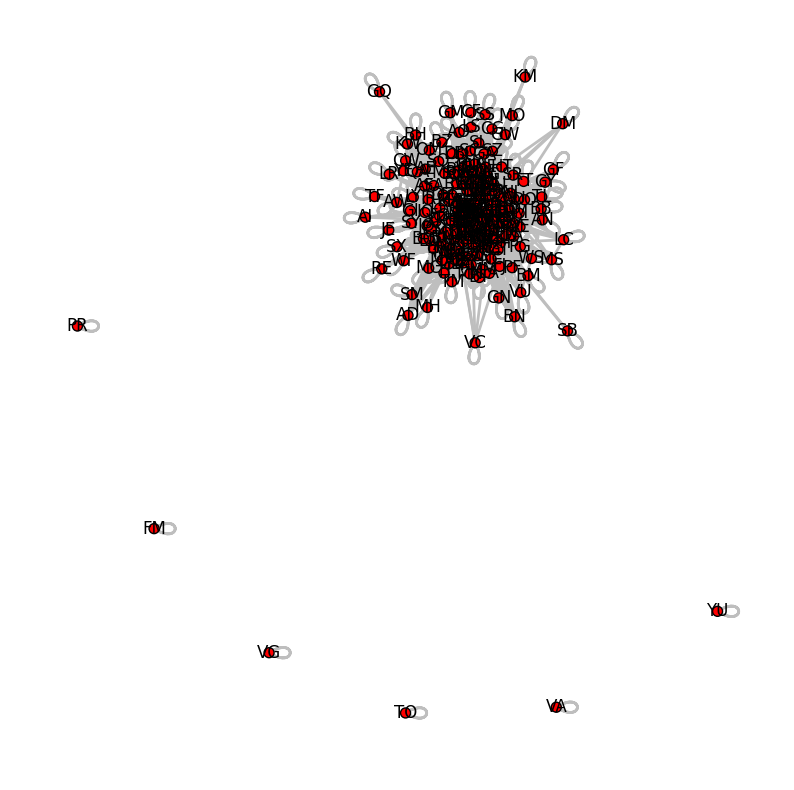

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
max_w = np.max(G.es['weight'])
ig.plot(G, vertex_label=G.vs['country_code'], vertex_size=10, edge_width=2, edge_color='gray', target=ax)

OK. That's a lot to digest, let's try to restrict to a country (e.g., Italy) and it's neighbors (collaborators).

In [ ]:
H = G.induced_subgraph(G.neighborhood(G.vs.find(country_code_eq = 'IT')))
H.summary()

'IGRAPH U-W- 180 6636 -- \n+ attr: country_code (v), weight (e)'

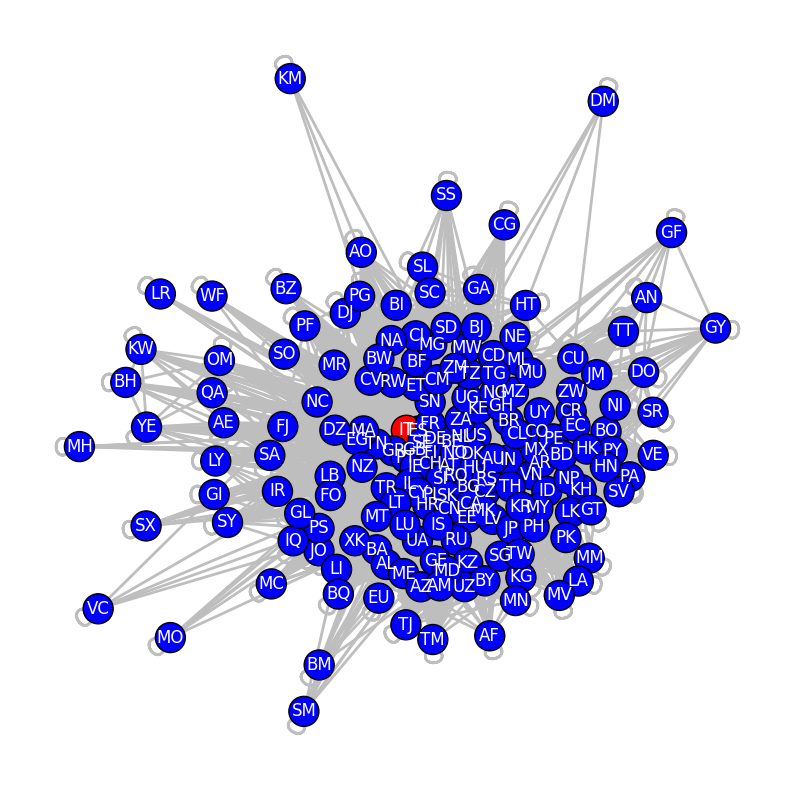

In [ ]:
H.vs['color'] = 'blue'
H.vs['label_color'] = 'white'
H.vs.find(country_code_eq = 'IT')['color'] = 'red'
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(H, vertex_label=H.vs['country_code'], vertex_size=30, edge_width=2, edge_color='gray',target=ax)

Let's select a reasonably small country to see a nice network.

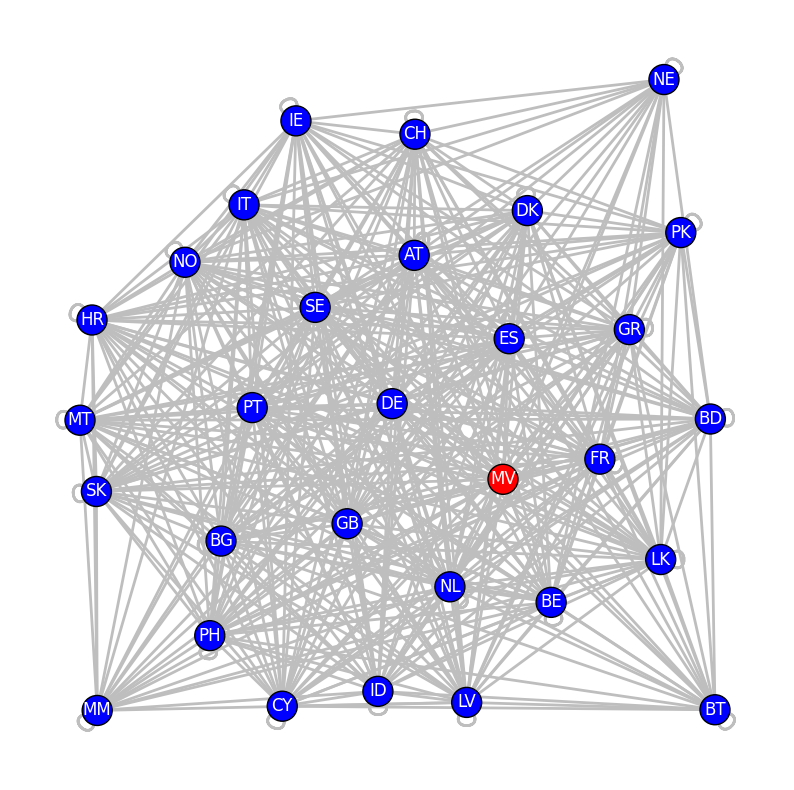

In [ ]:
country_code = 'MV' # MV = Maldives
H = G.induced_subgraph(G.neighborhood(G.vs.find(country_code_eq = country_code)))
H.summary()

H.vs['color'] = 'blue'
H.vs['label_color'] = 'white'
H.vs.find(country_code_eq = country_code)['color'] = 'red'
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(H, vertex_label=H.vs['country_code'], vertex_size=30, edge_width=2, edge_color='gray', target=ax)